Ноутбук очистки датасета с тиграми от Принцессы

In [1]:
import torch
import torchvision

from glob import glob

from PIL import Image

import pandas as pd

from torchvision import transforms

import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [3]:
model = model.cuda().eval()

In [4]:
def sim_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [17]:
all_tigers = glob('/data/tiger_vs_leo/Train_3500/3 класса/Тигры/*.jpg')

In [18]:
princess = glob('/data/tiger_vs_leo/Принцесса_400/*.jpg')

In [19]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
princess_features = {}

with torch.no_grad():
    for p in tqdm(princess):
        princess_features[p] = model(preprocess(Image.open(p)).cuda().unsqueeze(dim = 0)).cpu()[0].numpy()

/tmp/ipykernel_19428/2552903118.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm(princess):


  0%|          | 0/373 [00:00<?, ?it/s]

In [21]:
other_features = {}

with torch.no_grad():
    for p in tqdm(all_tigers):
        other_features[p] = model(preprocess(Image.open(p)).cuda().unsqueeze(dim = 0)).cpu()[0].numpy()

/tmp/ipykernel_19428/3159628697.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm(all_tigers):


  0%|          | 0/3500 [00:00<?, ?it/s]

In [24]:
princess_df = pd.DataFrame(princess_features.items(), columns = ['path', 'feature'])
all_tigers_df = pd.DataFrame(other_features.items(), columns = ['path', 'feature'])

In [36]:
with torch.no_grad():
    matrix = sim_matrix(torch.tensor(np.stack(princess_df.feature.values)).cuda(), torch.tensor(np.stack(all_tigers_df.feature.values)).cuda()).cpu().numpy()

In [94]:
duplicates = []

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        if matrix[i, j] > 0.96:
#             print(i, j, matrix[i, j])
#             print('-')
#             img = Image.open(all_tigers_df.loc[j].path)
#             img.thumbnail((256, 256))
#             display(img)
            duplicates.append(all_tigers_df.loc[j].path)
    
#             img = Image.open(princess_df.loc[i].path)
#             img.thumbnail((256, 256))
#             display(img)

# matrix > 0.97

In [100]:
all_tigers_df.shape

(3500, 2)

In [95]:
len(duplicates)

45

In [99]:
pd.Series(duplicates).to_csv('princess_in_all_tigers.csv', columns=None)

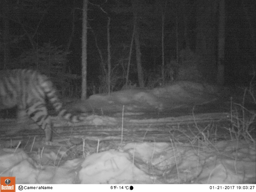

In [84]:
img = Image.open(all_tigers_df.loc[3449].path)
img.thumbnail((256, 256))
display(img)

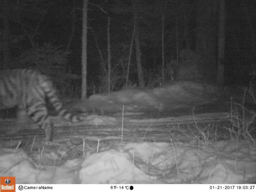

In [83]:
img = Image.open(princess_df.loc[9].path)
img.thumbnail((256, 256))
img